In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np
from slam.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation
from slam.basisv2 import CircuitTemplateV2
from slam.utils.gates.custom_gates import CirculatorSNAILGate, ConversionGainSmushGate
from slam.cost_function import BasicCostInverse, BasicCost, BasicReducedCost
from slam.optimizer import TemplateOptimizer
import h5py

In [5]:
t= 1.0
duration_1q = 0.25

# # if using riswap
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1), (1,2)]])
# basis_str = "riswap"

varg_offset = 0 #set to 4 if want to use phase, and change 0s to vargs in pp2 constructor below
pp2 =lambda *vargs: ConversionGainSmushGate(0,0 , np.pi/2, 0, vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp2], edge_params=[[(0,1)]], vz_only=False, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
basis_str = "iSwapSmush"

varg_offset = 2 #set to 4 if want to use phase, and change 0s to vargs in pp2 constructor below
pp2 =lambda *vargs: ConversionGainSmushGate(vargs[0],vargs[1] , np.pi/2, 0, vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp2], edge_params=[[(0,1)]], vz_only=False, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
basis_str = "iSwapSmush+P"


# varg_offset = 2 #set to 4 if want to use phase, and change 0s to vargs in pp2 constructor below
# pp2 =lambda *vargs: ConversionGainSmushGate(0,0 , vargs[0], vargs[1], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp2], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q"

# varg_offset = 4
# pp3 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp3], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q+P"


basis.build(1)
basis.spanning_range = range(1,2)

#for all smush gates make bounds
bounds_1q = np.pi
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, 0)

# # manually set the gc, gg bounds
# for el in basis.circuit.parameters:
#     s_el = str(el)
#     if s_el in [f"Q{varg_offset-2}", f"Q{1+varg_offset-2}", f"Q{22+varg_offset-2}", f"Q{23+varg_offset-2}", f"Q{44+varg_offset-2}", f"Q{45+varg_offset-2}"]: #XXX these need to be offset by varg_offset
#         #basis.add_bound(s_el, .5, 0)
#         basis.add_bound(s_el, 0.5*np.pi, 0) #XXX when using riswapgate should be 0.5, but when using ConversionGain should be np.pi/2 !!! BAD BAD BAD

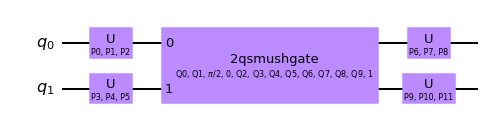

In [4]:
basis.circuit.draw(output='mpl')

In [13]:
# from slam.sampler import HaarSample
# sampler = HaarSample(seed=0,n_samples=1)
# s = [s for s in sampler][0]
from slam.utils.gates.custom_gates import RiSwapGate, BerkeleyGate
from qiskit.circuit.library import CXGate, SwapGate
from slam.sampler import HaarSample, GateSample
sampler = GateSample(gate = RiSwapGate(1/2))
sampler = GateSample(gate = SwapGate())
# sampler = GateSample(gate=SwapGate())
#sampler = GateSample(gate = BerkeleyGate())
s = [s for s in sampler][0]

In [14]:
from slam.cost_function import *
optimizer3 = TemplateOptimizer(basis=basis, objective=SquareCost(), use_callback=True, override_fail=True, success_threshold = 1e-15, training_restarts=3)
ret3 = optimizer3.approximate_from_distribution(sampler) #get coordinate list

INFO:root:Starting sample iter 0
INFO:root:Begin search: (0.5, 0.5, 0.5)
INFO:root:Starting opt on template size 1
100%|██████████| 3/3 [03:08<00:00, 62.82s/it]
INFO:root:Cycle (k =1), Best Loss=0.21715729582291277
INFO:root:Overall Best Loss=0.21715729582291277
INFO:root:Fail: (0.5, 0.5, 0.5), Found: (0.5, 0.25002761, 0.24997238)


/home/evm9/decomposition_EM/src/scripts/gate_exploration/../../../src/utils/visualize.py:296: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


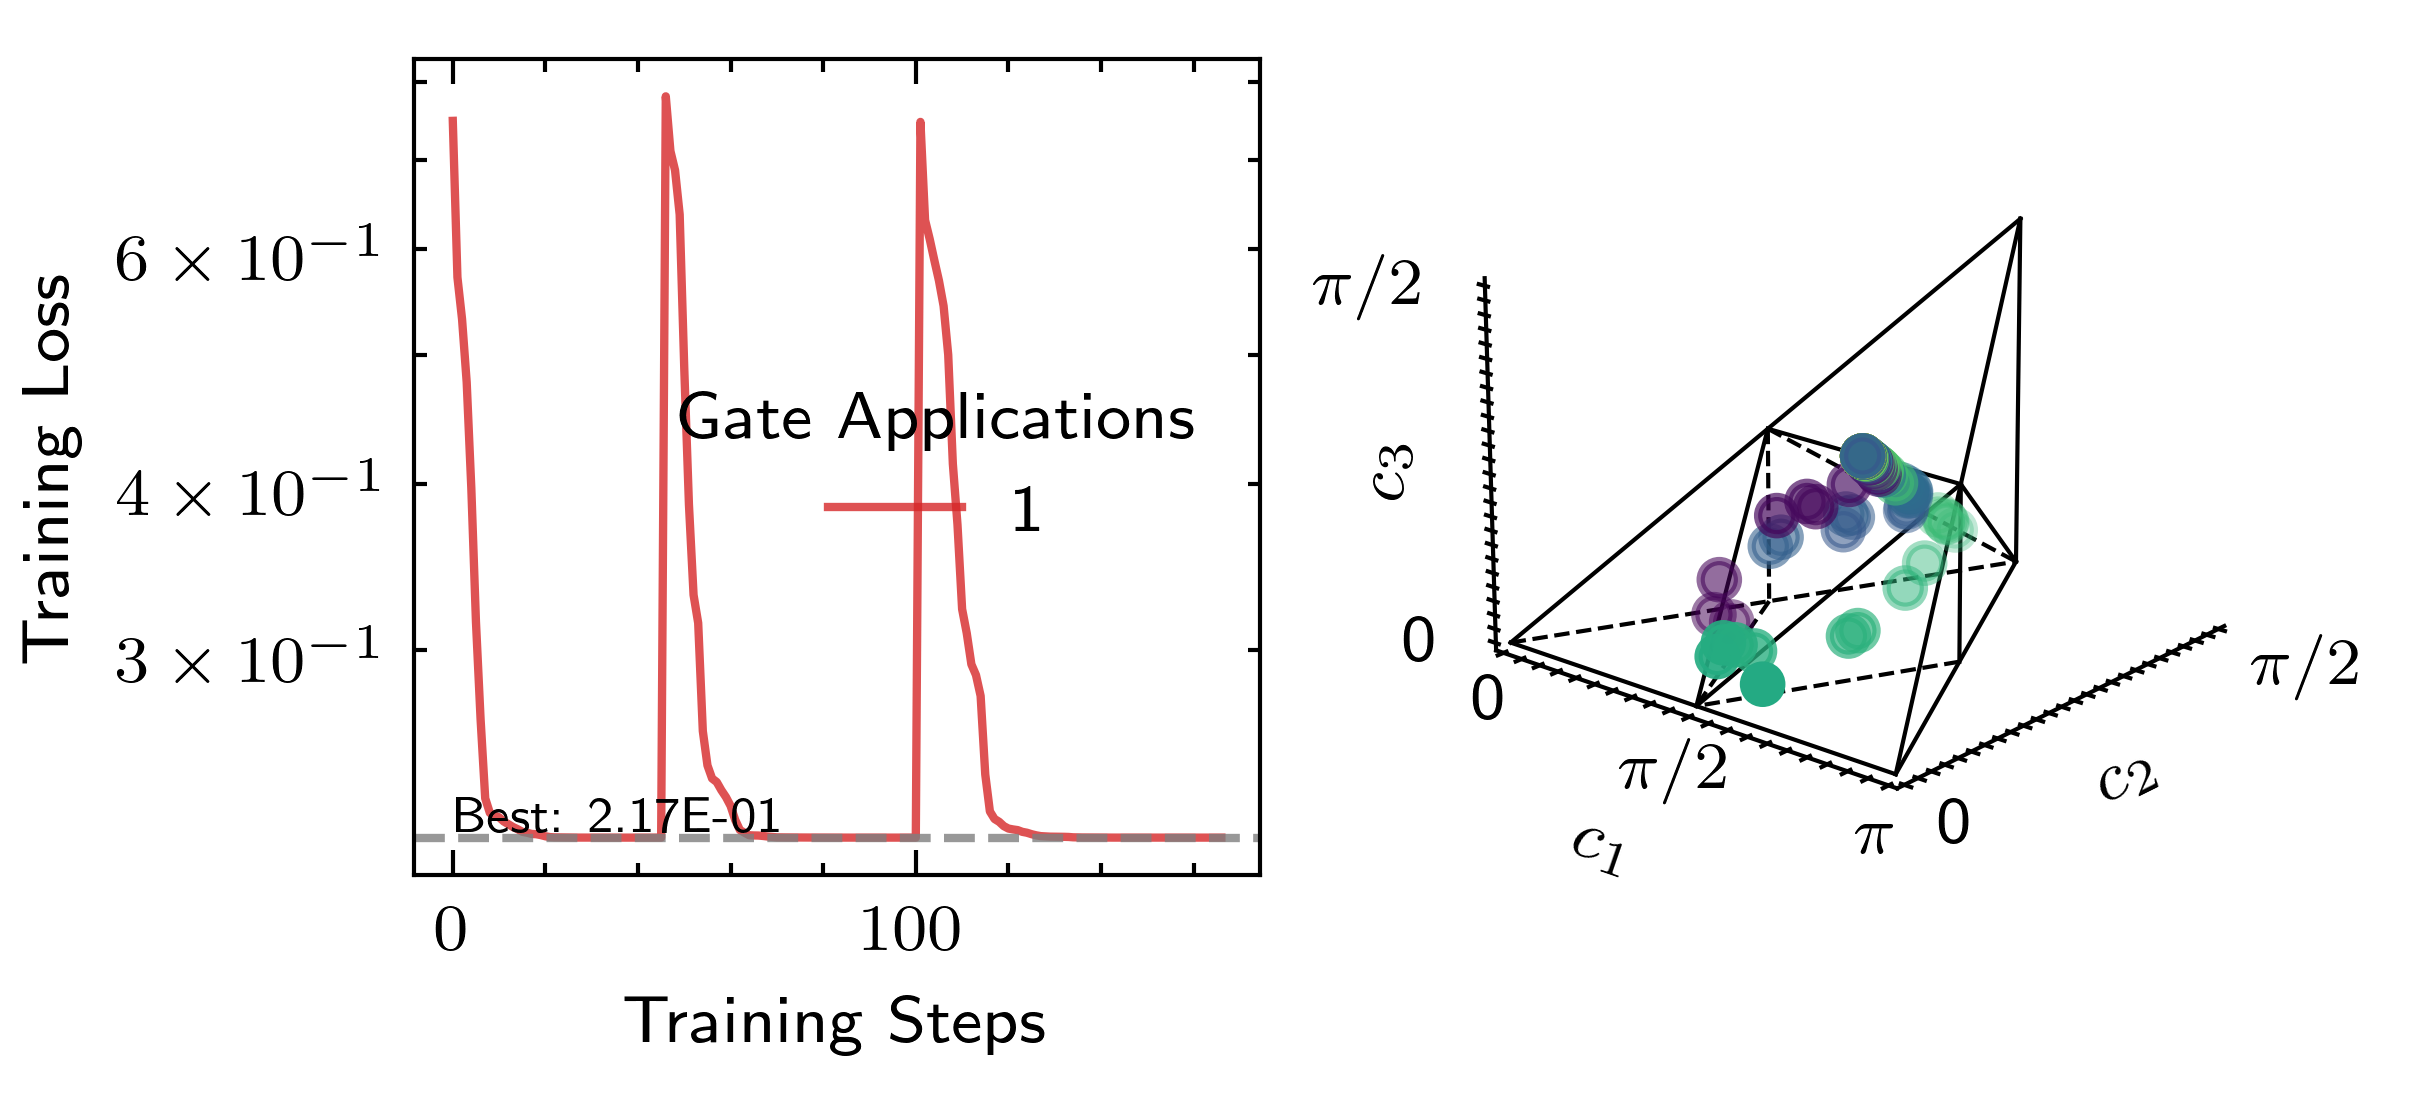

In [15]:
from slam.utils.visualize import optimizer_training_plot
fig = optimizer_training_plot(ret3[0], ret3[1], target_str="CXGate", gate_str="Parallel 1Q iSwap");
# save fig as svg and pdf
# from slam.utils.visualize import fpath
# fig.savefig(f"{fpath}/smush_{basis_str}_training.svg", format="svg")
# fig.savefig(f"{fpath}/smush_{basis_str}_training.pdf", format="pdf", bbox_inches='tight')

Cost: 1.0


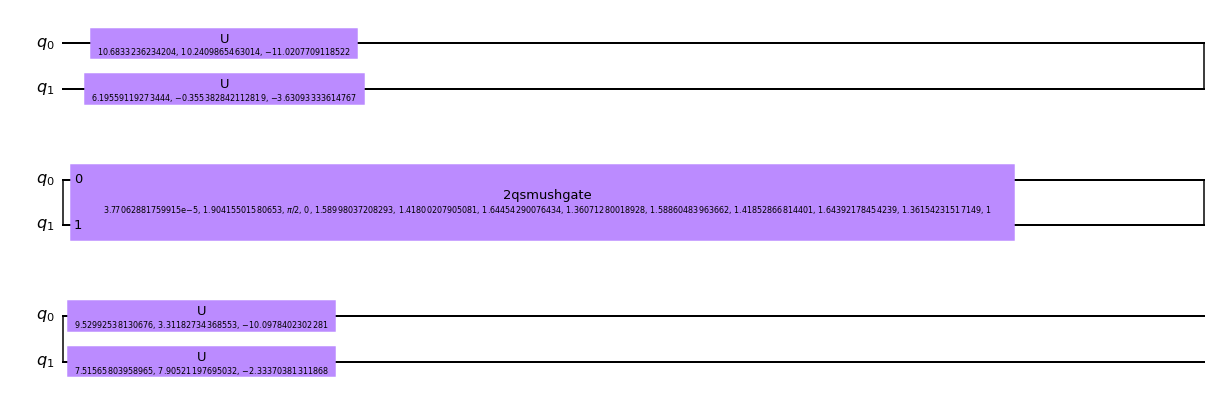

In [16]:
basis.reconstruct(ret3[2][0]).draw(output='mpl')

In [114]:
Operator(basis.reconstruct(ret3[2][0])).data

Cost: 1.0


array([[-9.46073893e-01-3.23950901e-01j,  7.52727300e-06+1.48322966e-05j,
         2.94187599e-05+7.74408998e-06j,  4.19924316e-05-1.55821066e-05j],
       [-2.36262549e-05-3.80524888e-05j, -1.76803539e-05-8.38430158e-06j,
         9.31614726e-06-1.53352949e-05j, -9.46063756e-01-3.23980505e-01j],
       [-2.79905333e-05-1.19149014e-05j, -4.85744092e-05-3.82839177e-07j,
        -9.46062499e-01-3.23984174e-01j,  2.04261036e-06-1.78273925e-05j],
       [-1.50375118e-05+7.10662866e-06j, -9.46068103e-01-3.23967809e-01j,
         3.86126018e-05+2.94739471e-05j,  1.91084645e-05+4.21392507e-06j]])

In [7]:
# Here we want to save the best cost as a function of the success threshold
# success_thresholds = [0.99, 0.999, 0.9999, 0.99999, 0.999999]
# fidelities = [None]*len(success_thresholds)
# for k, success_threshold in enumerate(success_thresholds):
#     objective1 = BasicCost()

objective1 = BasicCost()

# keep trying until success_threshold converges:
i=0
LB = 0
UB = 1
current_cost = (UB + LB)/2
print(f"Starting cost = {current_cost}")

# keep trying until success_threshold converges:
while i == 0 or np.abs(current_cost - previous_cost) > 0.01:
    if not current_cost is None:
        basis.set_constraint(param_max_cost=current_cost)
        #pass
    #rebuild optimizer to refresh the updated f_basis obj
    #NOTE setting the success threshold low since SWAP is very hard to find exactly
    optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=True, override_fail=True, success_threshold = 1e-7, training_restarts=5)

    _ret3 = optimizer3.approximate_target_U(s)
    current_cost = basis.circuit_cost(_ret3.Xk)
    print(f"Iteration:{i}, Decomposition Result:{_ret3.loss_result}, Cost:{current_cost},")

    #search using 2 steps forward, 1 step back approach BAD
    # I want to do a binary search between 0 and 1.5 
    # if success, then set next cost to be current - LB / 2
    # if fail, then set next cost to be current + (UB - current) / 2
    
    if _ret3.success_label:
        ret3 = _ret3
        #fidelities[k] = ret3

        #success means can tighten the constraint
        previous_cost = current_cost
        current_cost = (current_cost + LB)/2
        print("Success, new cost:", current_cost)
        #update UB
        UB = previous_cost

    else:
        #fail means loosen the constraint
        previous_cost = current_cost
        current_cost = (current_cost + UB)/2
        print("Fail, new cost:", current_cost)
        #update LB
        LB = previous_cost

    i+=1

    # # save fidelities to h5 file
    # with h5py.File(f'swap_fidelities_{basis_str}.h5', 'a') as hf:
    #     #if dataset exists, delete it
    #     if f"success_{success_threshold}" in hf:
    #         del hf[f"success_{success_threshold}"]
    #     hf.create_dataset(f"success_{success_threshold}", data=fidelities[k])

INFO:root:Begin search: (0.5, 0.0, 0.0)
INFO:root:Starting opt on template size 1


Starting cost = 0.5


100%|██████████| 5/5 [00:43<00:00,  8.77s/it]
INFO:root:Cycle (k =1), Best Loss=0.34675212077620565
INFO:root:Overall Best Loss=0.34675212077620565
INFO:root:Fail: (0.5, 0.0, 0.0), Found: (0.25, 0.04187323, 0.0064075)
INFO:root:Begin search: (0.5, 0.0, 0.0)
INFO:root:Starting opt on template size 1


Iteration:0, Decomposition Result:0.34675212077620565, Cost:0.5,
Fail, new cost: 0.75


 20%|██        | 1/5 [00:07<00:29,  7.50s/it]


KeyboardInterrupt: 

In [ ]:
# load best from h5
with h5py.File(f'sqiswap_fidelity.h5', 'r') as hf:
    #save ret3
    loss = hf['loss'][0]
    Xk = hf['Xk'][:]
    cycles = hf['cycles'][0]
    cost = hf['cost'][0]

# build the circuit
print(cost, loss)
#show the result of training
basis.build(cycles)
circuit =basis.assign_Xk(Xk)
circuit.draw()

0.12500000000001749 0.0614742657534455


»
q_0: »
     »
q_1: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                   ├
«     │  2qsmushgate(-3.14166745223154,-3.53809451621603,1π/8,3.00304233737071e-7,-3.83726519138434,3.83698884485411,3.83610061462769,-3.83629951531048,1) │
«q_1: ┤1                                                                                                                                                   ├
«     └────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘